## Fine-tuning Stable Diffusion XL with DreamBooth 🧨

In this notebook, we show how to fine-tune any Stable Diffusion model with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) 🧪.

## Setup 🪓

In [ ]:
# Check the GPU
!nvidia-smi

In [ ]:
# Install dependencies.
!pip install -U bitsandbytes transformers accelerate datasets peft

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git

In [10]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py

--2024-01-23 05:08:47--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57707 (56K) [text/plain]
Saving to: ‘train_dreambooth.py’

100%[======================================>] 57,707      --.-K/s   in 0.002s  

2024-01-23 05:08:47 (33.5 MB/s) - ‘train_dreambooth.py’ saved [57707/57707]

--2024-01-23 05:08:47--  https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP req

## Dataset 🐶

In [1]:
import os

# pick a name for the image folder
item = 'bracelet'
model = 'SG161222/Realistic_Vision_V2.0'
# models = ['SG161222/Realistic_Vision_V2.0', 'runwayml/stable-diffusion-v1-5', 'SG161222/Realistic_Vision_V5.1_noVAE',
#           'SG161222/Realistic_Vision_V3.0_VAE']
# https://huggingface.co/SG161222
instance_dir = f"images/{item}3/"
img_extension = 'jpeg'
output_dir = f'dreambooth/{item}3'
class_dir = f'images/class/{item}'
instance_prompt = f"photo of a sks {item}"
class_prompt =  f"photo of a {item}"
ckpt_path = f'{output_dir}/dreambooth_{item}3.safetensors'
instance_prompt = f"a photo of sks {item}"
fp16 = True

os.makedirs(output_dir, exist_ok=True)
!rm -rf $instance_dir/.ipynb_checkpoints
#!rm -rf output_dir

Preview the images:

In [2]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

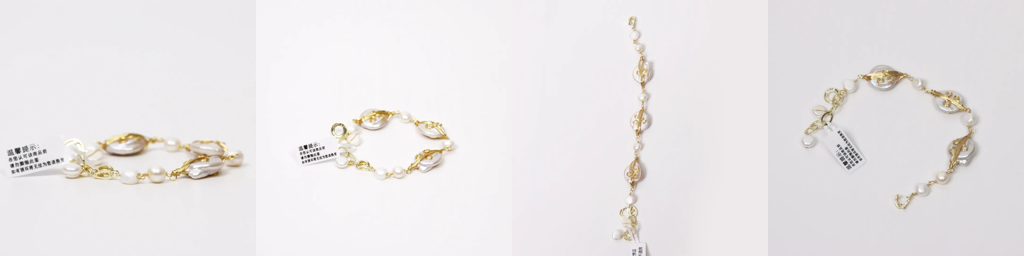

In [6]:
import glob

img_paths = f"{instance_dir}*.{img_extension}"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 4
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

## Prep for training 💻

### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [11]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

### Launch training 🚀🚀🚀

In [11]:
#!/usr/bin/env bash
#!python train_dreambooth.py \
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$model \
  --instance_data_dir=$instance_dir \
  --output_dir=$output_dir \
  --instance_prompt="$instance_prompt" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=5e-6 \
  --max_train_steps=400 \
  --lr_scheduler="constant" \
  --use_8bit_adam \
  --seed="1337" \
  --train_text_encoder \
  --sample_batch_size=4 \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16"
  #--with_prior_preservation --prior_loss_weight=1.0 \
  #--class_prompt="$class_prompt" \
  #--class_data_dir="$class_dir" \
  #--num_class_images=50 \

01/23/2024 05:09:38 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'timestep_spacing', 'dynamic_thresholding_ratio', 'clip_sample_range', 'thresholding', 'rescale_betas_zero_snr', 'sample_max_value'} was not found in config. Values will be initialized to default values.
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
{'scaling_factor', 'force_upcast'} was not found i

## Inference 🐕

In [12]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

seed = 0

pipe = DiffusionPipeline.from_pretrained(
    output_dir,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    safety_checker=None
).to("cuda")
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

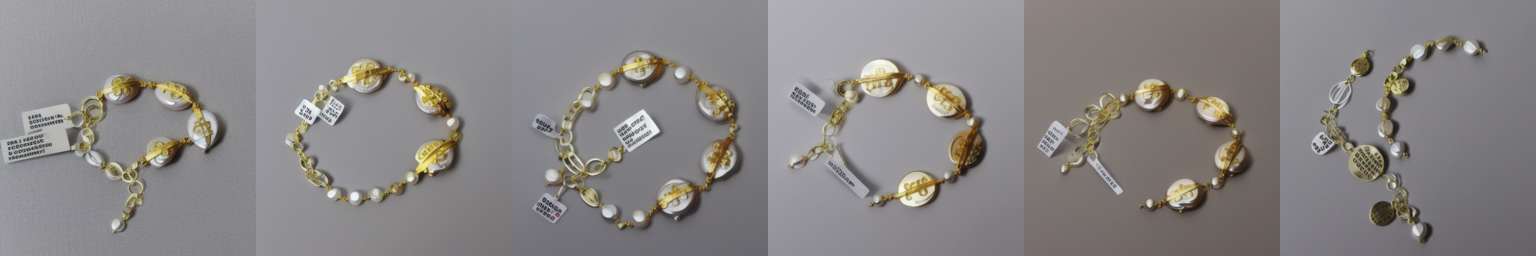

In [13]:
prompt = "photo of a sks bracelet"
negative_prompt = ""
n_samples = 6
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(seed)

images = pipe(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=n_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images

image_grid(images, 1, n_samples)

# Convert weights to Stable Diffusion

In [23]:
# Save to checkpoint file
half_arg = "--half" if fp16 else ""
!python convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $output_dir \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

[*] Converted ckpt saved at dreambooth/bracelet3/dreambooth_bracelet3.safetensors


In [24]:
# https://github.com/easydiffusion/easydiffusion/issues/1618
from safetensors import safe_open
from safetensors.torch import save_file

def fix_diffusers_model_conversion(load_path: str, save_path: str):
    # load original
    tensors = {}
    with safe_open(load_path, framework="pt") as f:
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    # migrate
    new_tensors = {}
    for k, v in tensors.items():
        new_key = k
        # only fix the vae
        if 'first_stage_model.' in k:
            # migrate q, k, v keys
            new_key = new_key.replace('.to_q.weight', '.q.weight')
            new_key = new_key.replace('.to_q.bias', '.q.bias')
            new_key = new_key.replace('.to_k.weight', '.k.weight')
            new_key = new_key.replace('.to_k.bias', '.k.bias')
            new_key = new_key.replace('.to_v.weight', '.v.weight')
            new_key = new_key.replace('.to_v.bias', '.v.bias')
        if new_key in ['first_stage_model.encoder.mid.attn_1.q.weight',
                      'first_stage_model.encoder.mid.attn_1.k.weight',
                      'first_stage_model.encoder.mid.attn_1.v.weight',
                      'first_stage_model.decoder.mid.attn_1.q.weight',
                      'first_stage_model.decoder.mid.attn_1.k.weight',
                      'first_stage_model.decoder.mid.attn_1.v.weight']:
            v = v.unsqueeze(-1).unsqueeze(-1)
        new_tensors[new_key] = v

    # save
    save_file(new_tensors, save_path)

def add_suffix_to_filename(path, suffix):
    dirname = os.path.dirname(path)
    filename = os.path.basename(path)
    filebase, extension = os.path.splitext(filename)
    new_filename = f"{filebase}{suffix}{extension}"
    new_path = os.path.join(dirname, new_filename)
    return new_path

ckpt_path_fixed = add_suffix_to_filename(ckpt_path, '_fixed')
fix_diffusers_model_conversion(load_path=ckpt_path, save_path=ckpt_path_fixed)

print(f"[*] Fixed ckpt saved at {ckpt_path_fixed}")

[*] Fixed ckpt saved at dreambooth/bracelet3/dreambooth_bracelet3_fixed.safetensors


In [18]:
!cp /home/ubuntu/stable-diffusion/sd-finetune/$ckpt_path_fixed /home/ubuntu/stable-diffusion/stable-diffusion-webui/models/Stable-diffusion/
#!mv /home/ubuntu/stable-diffusion/sd-finetune/$ckpt_path_fixed /home/ubuntu/stable-diffusion/stable-diffusion-webui/models/Stable-diffusion/

cp: cannot stat ‘/home/ubuntu/stable-diffusion/sd-finetune/dreambooth/bracelet3/dreambooth_bracelet3_fixed.safetensors’: No such file or directory


# Test converted weights

In [4]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import gc


if 'pipe' in locals():
  del pipe
gc.collect()
torch.cuda.empty_cache()
    
pipe = StableDiffusionPipeline.from_single_file(
    ckpt_path_fixed,
    torch_dtype=torch.float16,
    variant="fp16",
).to('cuda')

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

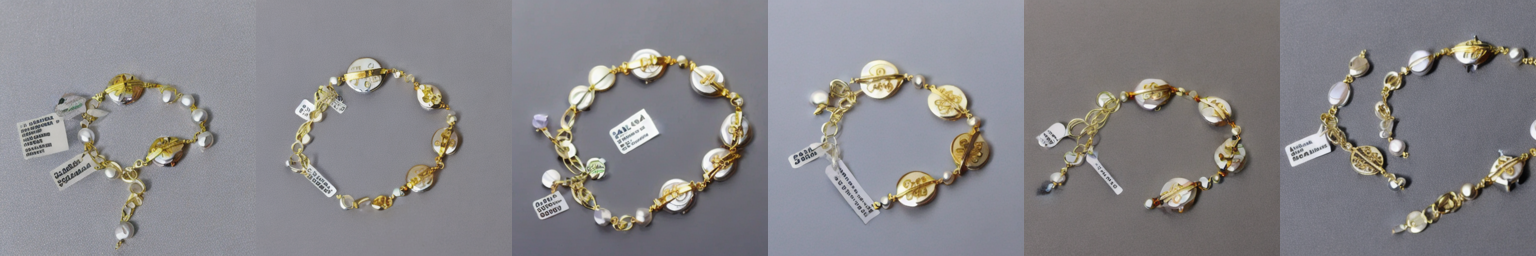

In [5]:
prompt = "a photo of sks bracelet"
negative_prompt = "disfigured, ugly, bad"
n_samples = 6
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

g_cuda = torch.Generator(device='cuda')
g_cuda.manual_seed(seed)

images = pipe(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=n_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images

image_grid(images, 1, n_samples)